# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [6]:
dropout_value=0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),            
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
             ReLU-10           [-1, 16, 24, 24]               0
        MaxPool2d-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           2,304
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):

    global train_max
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      loss = F.nll_loss(y_pred, target)
      train_losses.append(loss)
      
      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)
 
    if (train_max < 100*correct/processed):
        train_max = 100*correct/processed


def test(model, device, test_loader):

    global test_max
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    if (test_max < 100. * correct / len(test_loader.dataset)):
      test_max = 100. * correct / len(test_loader.dataset)
    
    test_acc.append(100. * correct / len(test_loader.dataset))


# Let's Train and test our model

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
train_max=0
test_max=0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

print(f"\nMaximum training accuracy: {train_max}\n")
print(f"\nMaximum test accuracy: {test_max}\n")


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.140570729970932 Batch_id=468 Accuracy=86.27: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0781, Accuracy: 9805/10000 (98.05%)

EPOCH: 1


Loss=0.03701375797390938 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.07883817702531815 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.01122888084501028 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


Loss=0.0562840960919857 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.010400363244116306 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 31.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.05102337524294853 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.03550403192639351 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.021458372473716736 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.08734434098005295 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.006304789800196886 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.022161632776260376 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.032333847135305405 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.02644813060760498 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.021004756912589073 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]



Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)


Maximum training accuracy: 99.27833333333334


Maximum test accuracy: 99.42



Text(0.5, 1.0, 'Test Accuracy')

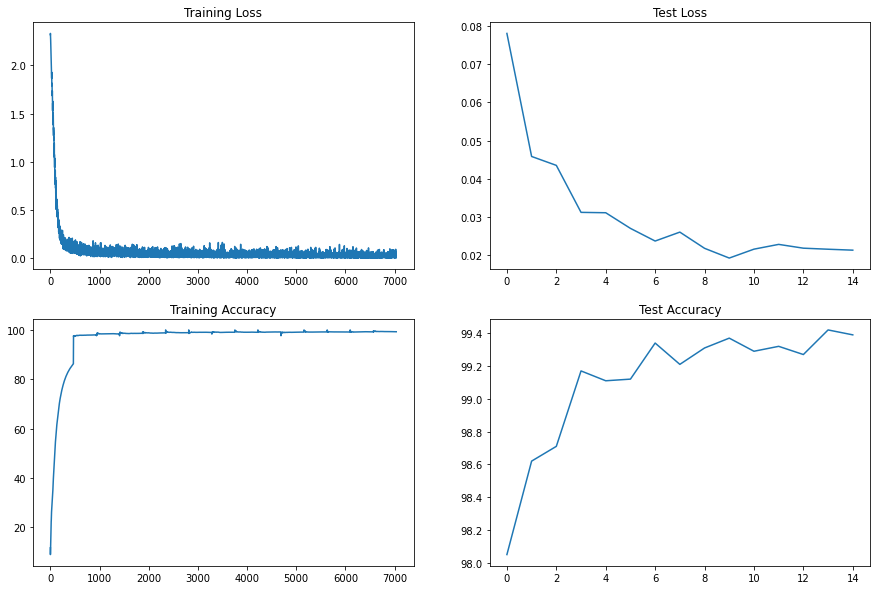

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

(0.0, 100.0)

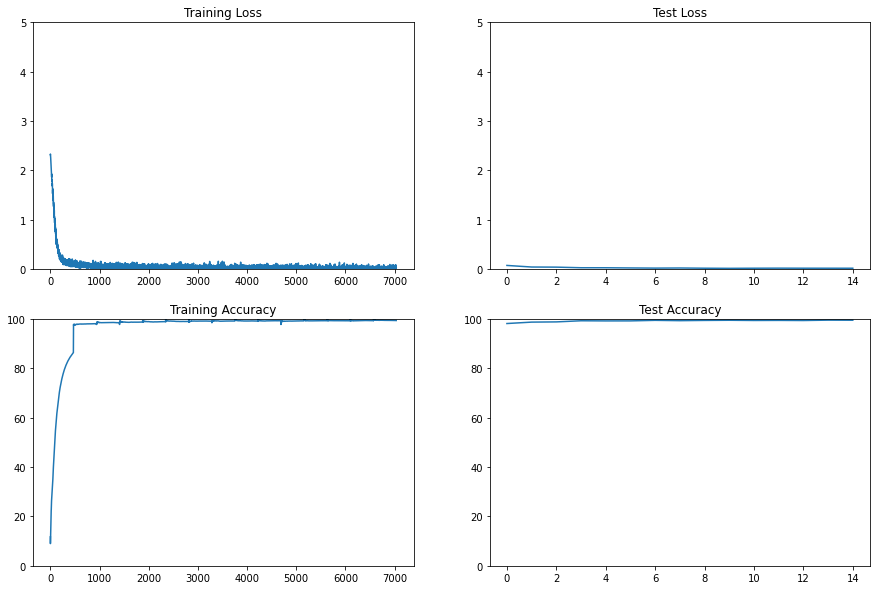

In [11]:
fig, ((axs1, axs2), (axs3, axs4)) = plt.subplots(2,2,figsize=(15,10)) 
# Train plot
axs1.plot(train_losses)
axs1.set_title("Training Loss")
axs3.plot(train_acc)
axs3.set_title("Training Accuracy")

# axs1.set_xlim([0, 5])
axs1.set_ylim([0, 5])
axs3.set_ylim([0, 100])


# Test plot
axs2.plot(test_losses)
axs2.set_title("Test Loss")
axs4.plot(test_acc)
axs4.set_title("Test Accuracy")

axs2.set_ylim([0, 5])
axs4.set_ylim([0, 100])
